# Exercise 1

# Graph definition

In [ ]:
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

# Nodes and base edges (u, v, capacity)
nodes = ['o','a','b','c','d']
base_edges = [
    ('o','a',3),
    ('a','d',3),
    ('o','b',3),
    ('b','c',3),
    ('c','d',2),
    ('a','b',1),
]

def build_graph(edges):
    """Build and return a NetworkX DiGraph with capacity attributes."""
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for (u,v,c) in edges:
        G.add_edge(u, v, capacity=c)
    return G

G0 = build_graph(base_edges)



#--- plot graph
pos = {
    'o': (0, 0.5),
    'a': (1, 1),
    'b': (1, 0),
    'c': (2, 0),
    'd': (3, 0.5)
}
edge_labels = { (u,v): G0.get_edge_data(u,v)['capacity'] for u,v in G0.edges() }

plt.figure(figsize=(8, 4))
nx.draw(G0, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
nx.draw_networkx_edge_labels(G0, pos, edge_labels=edge_labels, label_pos=0.3, font_color='red')
plt.title("Oriented Graph Exercise_1")
plt.show()

# A : Capacity and cut

The minimum capacity to be removed for no feasible flow from $o$ to $d$ to exist is the capacity of the minimum cut, which is 5. This can be achieved by removing the edges in one of the minimum cuts (e.g., edges $(o, a)$ and $(c, d)$, or edges $(a, d)$ and $(c, d)$), or reducing their capacities to zero.


In [ ]:

def cut_capacity(edges, S):
    """Compute capacity of cut (S, V\\S) for given edges list."""
    S = set(S)
    return sum(c for (u,v,c) in edges if (u in S and v not in S))



all_cuts = []
for r in range(1, len(nodes)):
    for comb in combinations(nodes, r):
        if 'o' in comb and 'd' not in comb:
            all_cuts.append((set(comb), cut_capacity(base_edges, comb)))

all_cuts_sorted = sorted(all_cuts, key=lambda x: x[1])

for S, cap in all_cuts_sorted:
    print(f"Capacity = {cap}  =>  Set = {sorted(S)}")

min_cut_value, (S_min, T_min) = nx.minimum_cut(G0, 'o', 'd', capacity='capacity')
print("\nMinimum s-t cut capacity :", min_cut_value)
print("Maximum flow from o to d :", nx.maximum_flow_value(G0, 'o', 'd', capacity='capacity'))


Capacity = 5  =>  Set = ['b', 'c', 'o']
Capacity = 5  =>  Set = ['a', 'b', 'c', 'o']
Capacity = 6  =>  Set = ['o']
Capacity = 6  =>  Set = ['b', 'o']
Capacity = 6  =>  Set = ['a', 'b', 'o']
Capacity = 7  =>  Set = ['a', 'o']
Capacity = 8  =>  Set = ['c', 'o']
Capacity = 9  =>  Set = ['a', 'c', 'o']

Minimum s-t cut capacity : 5
One minimum cut S side: ['a', 'b', 'c', 'o']
Maximum flow from o to d : 5


# B : Maximize the throughput




## B_1:   Brute-Force
We search optimal integer allocations of x among the 6 original edges to maximize o->d throughput

The code try all the possible configuration e pick the best one thanks to the min-cut max-flow theorem 

No feasible if the number of edge is large, it increase exponential the computation increasing X.



X, best_flow, best_allocation):
0 (5, (0, 0, 0, 0, 0, 0))
1 (6, (0, 0, 0, 0, 1, 0))
2 (6, (0, 0, 0, 0, 1, 1))
3 (7, (1, 1, 0, 0, 1, 0))
4 (7, (0, 0, 1, 1, 2, 0))
5 (8, (2, 2, 0, 0, 1, 0))
6 (8, (1, 1, 1, 1, 2, 0))
7 (9, (3, 3, 0, 0, 1, 0))
8 (9, (2, 2, 1, 1, 2, 0))
9 (10, (4, 4, 0, 0, 1, 0))
10 (10, (3, 3, 1, 1, 2, 0))
11 (11, (5, 5, 0, 0, 1, 0))
12 (11, (4, 4, 1, 1, 2, 0))
13 (12, (6, 6, 0, 0, 1, 0))
14 (12, (5, 5, 1, 1, 2, 0))
15 (13, (7, 7, 0, 0, 1, 0))


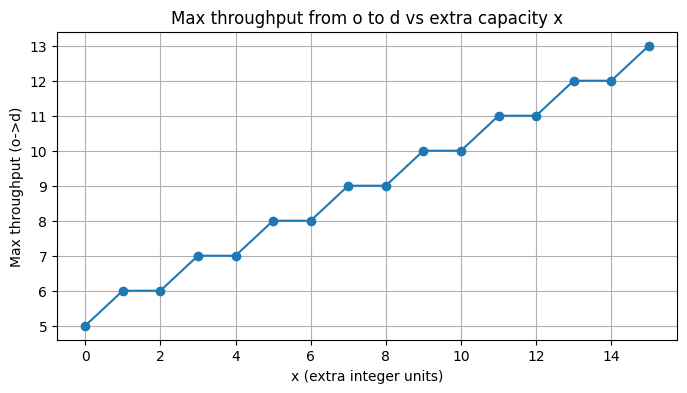

In [9]:
def compositions(n, k):
    """Generate all compositions of integer n into k nonnegative integers (tuples)."""
    if k == 1:
        yield (n,)
    else:
        for i in range(n+1):
            for tail in compositions(n-i, k-1):
                yield (i,) + tail

BASE_CAPS = [c for (_,_,c) in base_edges]

def max_throughput_with_extra_on_original(x_max_search=15):
    """For x in 0..x_max_search, find best integer allocation among the original edges."""
    results = {}
    for X in range(0, x_max_search+1):
        best_val = -1
        best_alloc = None
        for alloc in compositions(X, len(BASE_CAPS)):  # alloc is tuple of length 6
            new_edges = [(u,v, c + alloc[i]) for i, (u,v,c) in enumerate(base_edges)]
            G = build_graph(new_edges)
            val = nx.maximum_flow_value(G, 'o', 'd', capacity='capacity')
            if val > best_val:
                best_val = val
                best_alloc = alloc
        results[X] = (best_val, best_alloc)
    return results

XMAX = 15
results_b = max_throughput_with_extra_on_original(XMAX)

print("\nX, best_flow, best_allocation):")
for x in range(0, XMAX+1):
    print(x, results_b[x])

xs = list(range(0, XMAX+1))
flows_b = [results_b[x][0] for x in xs]

plt.figure(figsize=(8,4))
plt.plot(xs, flows_b, marker='o')
plt.title('Max throughput from o to d vs extra capacity x')
plt.xlabel('x (extra integer units)')
plt.ylabel('Max throughput (o->d)')
plt.grid(True)
plt.show()


## B_2 : Greedy Heuristic
Add capacity always to an edge of the current minimum cut, we choose the arch with the "best rewards".
Faster than Brute-Force, not optimal in the solution.

Improved greedy heuristic:

At each step:
  1. Compute min-cut.
  2. For each crossing edge, simulate +1 capacity and measure
     the max-flow increase.
  3. Choose the edge giving the largest gain.
  4. Apply the increment for real.

Returns:
  1. final_flow: maximum flow after allocation.
  2. allocation: tuple of added capacities (same order as base_edges).
  3. history: max-flow after each unit allocation.

x | improved_flow | allocation
 0               5   (0, 0, 0, 0, 0, 0)
 1               6   (0, 0, 0, 0, 1, 0)
 2               6   (0, 1, 0, 0, 1, 0)
 3               7   (1, 1, 0, 0, 1, 0)
 4               7   (1, 1, 0, 0, 2, 0)
 5               7   (1, 1, 0, 1, 2, 0)
 6               8   (1, 1, 1, 1, 2, 0)
 7               8   (1, 2, 1, 1, 2, 0)
 8               9   (2, 2, 1, 1, 2, 0)
 9               9   (2, 2, 1, 1, 3, 0)
10               9   (2, 2, 1, 2, 3, 0)
11              10   (2, 2, 2, 2, 3, 0)
12              10   (2, 3, 2, 2, 3, 0)
13              11   (3, 3, 2, 2, 3, 0)
14              11   (3, 3, 2, 2, 4, 0)
15              11   (3, 3, 2, 3, 4, 0)
16              12   (3, 3, 3, 3, 4, 0)
17              12   (3, 4, 3, 3, 4, 0)
18              13   (4, 4, 3, 3, 4, 0)
19              13   (4, 4, 3, 3, 5, 0)
20              13   (4, 4, 3, 4, 5, 0)
21              14   (4, 4, 4, 4, 5, 0)
22              14   (4, 5, 4, 4, 5, 0)
23              15   (5, 5, 4, 4, 5, 0)
24       

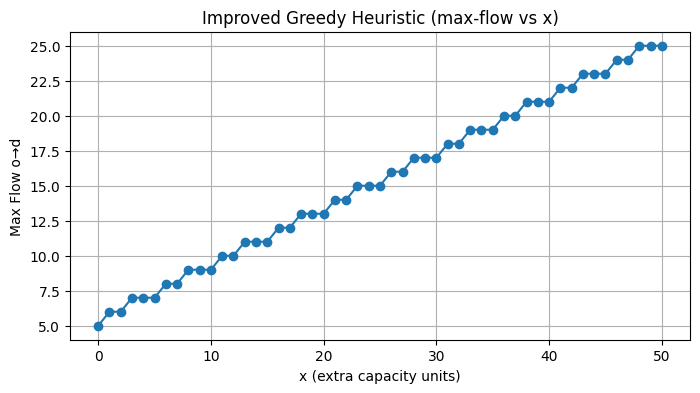

In [7]:
def greedy_improved(x):

    # Make edges mutable
    edges = [[u, v, c] for (u,v,c) in base_edges]
    allocation = [0]*len(edges)
    history = []

    # Initial flow
    G = build_graph([(u,v,c) for (u,v,c) in edges])
    current_flow = nx.maximum_flow_value(G, 'o', 'd')
    history.append(current_flow)

    for step in range(x):

        # 1. Compute min-cut
        cut_value, (S, T) = nx.minimum_cut(G, 'o', 'd')

        # Crossing edges
        crossing = [i for i,(u,v,c) in enumerate(edges) if u in S and v in T]

        if not crossing:
            # No more useful edges to increase
            history.extend([current_flow]*(x-step))
            break

        # 2. Evaluate each candidate edge by simulating +1 capacity
        best_gain = -1
        best_i = None

        for i in crossing:
            u, v, c = edges[i]

            # Simulate +1
            edges[i][2] = c + 1
            G_test = build_graph([(u2,v2,c2) for (u2,v2,c2) in edges])
            new_flow = nx.maximum_flow_value(G_test, 'o', 'd')
            gain = new_flow - current_flow

            # Restore original before next test
            edges[i][2] = c

            # Select the edge with largest gain
            # Tie-break: choose the one with smallest current capacity
            if gain > best_gain or (gain == best_gain and c < edges[best_i][2]):
                best_gain = gain
                best_i = i

        # 3. Apply real increment
        edges[best_i][2] += 1
        allocation[best_i] += 1

        # 4. Update flow
        G = build_graph([(u,v,c) for (u,v,c) in edges])
        current_flow = nx.maximum_flow_value(G, 'o', 'd')
        history.append(current_flow)

    return current_flow, tuple(allocation), history


XMAX = 50
print("x | improved_flow | allocation")
for x in range(XMAX+1):
    f, alloc, h = greedy_improved(x)
    print(f"{x:2d}   {f:13d}   {alloc}")


# ---- Plot ----
xs = list(range(XMAX+1))
flows = [greedy_improved(x)[0] for x in xs]

plt.figure(figsize=(8,4))
plt.plot(xs, flows, marker='o')
plt.title("Improved Greedy Heuristic (max-flow vs x)")
plt.xlabel("x (extra capacity units)")
plt.ylabel("Max Flow o→d")
plt.grid(True)
plt.show()


# C : Extra link

## C_1 : BRUTEFORCE

add an extra directed link e8 with base cap 1 and distribute x among all edges

It try all the possible configuration, No feasible to big graph or extra-flow


=== PART (C) RESULTS -BRUTEFORCE- ===
x=0:   max_flow=6   new_edge=('b', 'd')   alloc=(0, 0, 0, 0, 0, 0, 0)
x=1:   max_flow=6   new_edge=('o', 'c')   alloc=(0, 0, 0, 0, 1, 0, 0)
x=2:   max_flow=7   new_edge=('o', 'c')   alloc=(0, 0, 0, 0, 2, 0, 0)
x=3:   max_flow=7   new_edge=('o', 'c')   alloc=(0, 0, 0, 0, 2, 0, 1)
x=4:   max_flow=8   new_edge=('o', 'c')   alloc=(0, 0, 0, 0, 3, 0, 1)
x=5:   max_flow=8   new_edge=('o', 'c')   alloc=(0, 0, 0, 0, 3, 0, 2)
x=6:   max_flow=9   new_edge=('o', 'c')   alloc=(0, 0, 0, 0, 4, 0, 2)
x=7:   max_flow=9   new_edge=('o', 'c')   alloc=(0, 0, 0, 0, 4, 0, 3)
x=8:   max_flow=10   new_edge=('o', 'c')   alloc=(0, 0, 0, 0, 5, 0, 3)
x=9:   max_flow=10   new_edge=('o', 'c')   alloc=(0, 0, 0, 0, 5, 0, 4)
x=10:   max_flow=11   new_edge=('o', 'c')   alloc=(0, 0, 0, 0, 6, 0, 4)


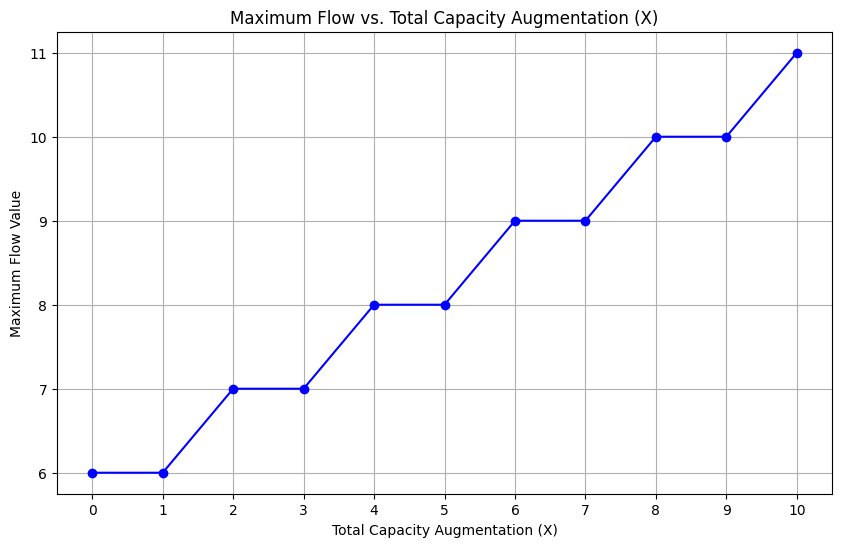

In [15]:
def part_c_max_flow(XMAX=10):
    # Get candidate new edges
    existing_pairs = [(u,v) for (u,v,_) in base_edges]
    all_pairs = [(u,v) for u in nodes for v in nodes if u != v]
    
    # EXCLUDE the illegal edge that breaks the graph structure
    illegal = [('o','d')]
    
    candidate_new = [
        p for p in all_pairs 
        if p not in existing_pairs and p not in illegal
    ]
    
    results = {}
    for X in range(XMAX+1):
        best_flow = -1
        best_position = None
        best_alloc = None
        
        for (u_new, v_new) in candidate_new:
            
            M = len(base_edges) + 1
            for alloc in compositions(X, M):
                
                # Build edges with updated capacities
                new_edges = [
                    (u, v, c + alloc[i]) 
                    for i, (u,v,c) in enumerate(base_edges)
                ]
                
                # NEW EDGE with base capacity = 1
                new_edges.append((u_new, v_new, 1 + alloc[-1]))
                
                G = build_graph(new_edges)
                flow = nx.maximum_flow_value(G, 'o', 'd')
                
                if flow > best_flow:
                    best_flow = flow
                    best_position = (u_new, v_new)
                    best_alloc = alloc
        
        results[X] = (best_flow, best_position, best_alloc)
    
    return results


# Run up to X = 10
results_c = part_c_max_flow(10)

print("\n=== PART (C) RESULTS -BRUTEFORCE- ===")
for X in range(11):
    flow, pos, alloc = results_c[X]
    print(f"x={X}:   max_flow={flow}   new_edge={pos}   alloc={alloc}")

# PLOT
X_values = sorted(results_c.keys())
max_flow_values = [results_c[X][0] for X in X_values]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(X_values, max_flow_values, marker='o', linestyle='-', color='b')

# Add labels and title
plt.title('Maximum Flow vs. Total Capacity Augmentation (X)')
plt.xlabel('Total Capacity Augmentation (X)')
plt.ylabel('Maximum Flow Value')
plt.xticks(X_values) # Ensure all X values are displayed on the x-axis
plt.grid(True)
plt.show()

## C_2: GREEDY HEURISTIC

Among all allowed new edges, choose the one that increases the max-flow the most when added with base capacity = 1.

Heuristic: chosen new edge = ('b', 'd') initial flow = 6
x=0 → throughput=6
x=1 → throughput=6
x=2 → throughput=7
x=3 → throughput=7
x=4 → throughput=7
x=5 → throughput=8
x=6 → throughput=8
x=7 → throughput=9
x=8 → throughput=9
x=9 → throughput=10
x=10 → throughput=10
x=11 → throughput=10
x=12 → throughput=11
x=13 → throughput=11
x=14 → throughput=11
x=15 → throughput=12
x=16 → throughput=12
x=17 → throughput=13
x=18 → throughput=13
x=19 → throughput=13
x=20 → throughput=14
x=21 → throughput=14
x=22 → throughput=15
x=23 → throughput=15
x=24 → throughput=16
x=25 → throughput=16
x=26 → throughput=16
x=27 → throughput=17
x=28 → throughput=17
x=29 → throughput=17
x=30 → throughput=18
x=31 → throughput=18
x=32 → throughput=19
x=33 → throughput=19
x=34 → throughput=19
x=35 → throughput=20
x=36 → throughput=20
x=37 → throughput=21
x=38 → throughput=21
x=39 → throughput=22
x=40 → throughput=22
x=41 → throughput=22
x=42 → throughput=23
x=43 → throughput=23
x=44 → throughput=23
x=45 → throughput

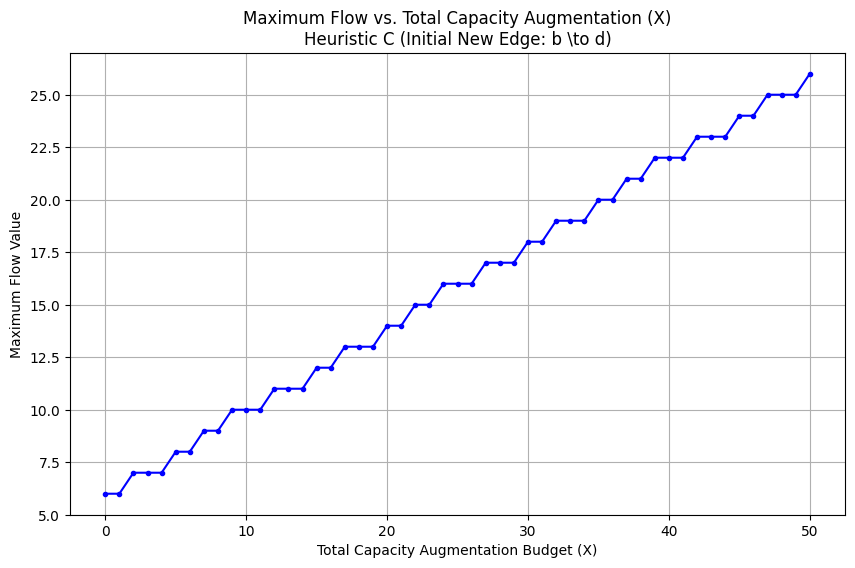

In [ ]:
def find_best_new_edge_heuristic():

    existing_pairs = [(u,v) for (u,v,_) in base_edges]
    all_pairs = [(u,v) for u in nodes for v in nodes if u != v]
    
    # EXCLUDE o→d (illegal / trivial cut removal)
    illegal = [('o','d')]
    candidate_new = [
        p for p in all_pairs 
        if p not in existing_pairs and p not in illegal
    ]
    
    best_flow = -1
    best_edge = None
    
    for (u,v) in candidate_new:
        edges_aug = base_edges + [(u, v, 1)]
        G = build_graph(edges_aug)
        f = nx.maximum_flow_value(G, 'o', 'd')
        
        if f > best_flow:
            best_flow = f
            best_edge = (u, v)
    
    return best_edge, best_flow


def heuristic_C(max_x=10):
    
    # Step 1 — choose the new edge
    best_edge, base_flow = find_best_new_edge_heuristic()
    print("Heuristic: chosen new edge =", best_edge,
          "initial flow =", base_flow)
    
    # Start with base capacities
    flows = []
    edges_current = list(base_edges) + [(best_edge[0], best_edge[1], 1)]
    
    for x in range(max_x+1):
        
        # Build graph
        G = build_graph(edges_current)
        f, (S, T) = nx.minimum_cut(G, 'o', 'd')
        
        flows.append(f)
        
        # If we still have units to assign, increase the min-capacity edge in the cut
        if x < max_x:
            crossing = []
            for (u,v,c) in edges_current:
                if u in S and v in T:
                    crossing.append((u,v,c))
            
            # Choose edge with smallest capacity
            u_min, v_min, c_min = min(crossing, key=lambda z: z[2])
            
            # Update its capacity by +1
            edges_current = [
                (u,v,c+1) if (u==u_min and v==v_min and c==c_min) else (u,v,c)
                for (u,v,c) in edges_current
            ]
    
    return flows, best_edge



flows_C_heur, best_new_edge = heuristic_C(50)

for x, f in enumerate(flows_C_heur):
    print(f"x={x} → throughput={f}")

# PLOTwha
X_values = list(range(len(flows_C_heur)))
max_flow_values = flows_C_heur

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(X_values, max_flow_values, marker='.', linestyle='-', color='b')

# Add labels and title
plt.title(f'Maximum Flow vs. Total Capacity Augmentation (X)\nHeuristic C (Initial New Edge: {best_new_edge[0]} \\to {best_new_edge[1]})')
plt.xlabel('Total Capacity Augmentation Budget (X)')
plt.ylabel('Maximum Flow Value')
plt.grid(True)
plt.show()
